# Data transformation with the help of Ask-Tell interface.

In [1]:
import os

import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from util.plotting import plot_regret

import trieste
from trieste.ask_tell_optimization import AskTellOptimizer
from trieste.data import Dataset
from trieste.models.gpflow import GaussianProcessRegression
from trieste.models.optimizer import Optimizer
from trieste.objectives import TRID_10_MINIMUM, TRID_10_SEARCH_SPACE, trid_10
from trieste.objectives.utils import mk_observer
from trieste.space import Box

np.random.seed(1794)
tf.random.set_seed(1794)

# silence TF warnings and info messages, only print errors
# https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.get_logger().setLevel("ERROR")

## Describe the problem

In this notebook, we show how to perform data transformation during Bayesian optimization. This is usually required by the models. A very common example is normalising the data before fitting the model, either min-max or standard normalization. This is usually done for numerical stability, or to improve or speed up the convergence.

In regression problems it is easy to perform data transformations as you do it once before training. In Bayesian optimization this is more complex, as the data added with each iteration and needs to be transformed as well before the model is updated. At the moment Trieste cannot do such transformations for the user. Luckily, this can be easily done by using the [Ask-Tell interface](ask_tell_optimization.ipynb), as it provides greater control of the optimization loop. The disadvantage is that it is up to the user to take care of all the data transformation.

As an example, we will be searching for a minimum of a 10-dimensional [Trid function](https://www.sfu.ca/~ssurjano/trid.html). The range of variation of the Trid function values is large. It varies from values of $10^5$ to its global minimum $f(x^∗) = −210$. This large variation range makes it difficult for Bayesian optimization with Gaussian processes to find the global minimum. However, with data normalisation it becomes possible (see <cite data-cite="hebbal2019bayesian">[Hebbal et al. 2019](https://arxiv.org/abs/1905.03350)</cite>).

In [2]:
function = trid_10
F_MINIMUM = TRID_10_MINIMUM
search_space = TRID_10_SEARCH_SPACE

## Collect initial points

We set up the observer as usual over the Trid function search space, using Sobol sampling to sample the initial points.

In [3]:
num_initial_points = 50

observer = mk_observer(function)

initial_query_points = search_space.sample_sobol(num_initial_points)
initial_data = observer(initial_query_points)

## Model the objective function

The Bayesian optimization procedure estimates the next best points to query by using a probabilistic model of the objective. We'll use a Gaussian process (GP) model, built using GPflow. The GPflow models cannot be used directly in our Bayesian optimization routines, so we build a GPflow's `GPR` model and pass it to the `GaussianProcessRegression` wrapper.

Here as the first example, we model the objective function using the original data, without performing any data transformation. In the next example we will model it using normalised data. We also put priors on the parameters of our GP model's kernel in order to stabilize model fitting. We found the priors below to be highly effective for objective functions defined over the unit hypercube and with an output normalised to have zero mean and unit variance. Since the non-normalised data from the original objective function comes with different scaling, we rescale the priors based on approximate standard deviation of inputs and outputs.

In [4]:
def build_gp_model(data, x_std=1.0, y_std=0.1):

    dim = data.query_points.shape[-1]
    empirical_variance = tf.math.reduce_variance(data.observations)

    prior_lengthscales = [0.2 * x_std * np.sqrt(dim)] * dim
    prior_scale = tf.cast(1.0, dtype=tf.float64)

    x_std = tf.cast(x_std, dtype=tf.float64)
    y_std = tf.cast(y_std, dtype=tf.float64)

    kernel = gpflow.kernels.Matern52(
        variance=empirical_variance,
        lengthscales=prior_lengthscales,
    )
    kernel.variance.prior = tfp.distributions.LogNormal(
        tf.math.log(y_std), prior_scale
    )
    kernel.lengthscales.prior = tfp.distributions.LogNormal(
        tf.math.log(kernel.lengthscales), prior_scale
    )
    gpr = gpflow.models.GPR(
        data.astuple(),
        kernel,
        mean_function=gpflow.mean_functions.Constant(),
        noise_variance=1e-5,
    )
    gpflow.set_trainable(gpr.likelihood, False)

    return GaussianProcessRegression(gpr)


model = build_gp_model(initial_data, 20, 10000)

## Run the optimization loop

We can now run the Bayesian optimization loop by defining a `BayesianOptimizer` and calling its `optimize` method.

The optimizer uses an acquisition rule to choose where in the search space to try on each optimization step. We'll be using Expected improvement acquisition function - it is used by default, so no need to specify it.

We'll run the optimizer for 100 steps. Note: this may take a while!

In [5]:
num_steps = 100

bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
result = bo.optimize(num_steps, initial_data, model)
dataset = result.try_get_final_dataset()

Optimization completed without errors


## Explore the results

We can now get the best point found by the optimizer. Note this isn't necessarily the point that was last evaluated. We will also plot regret for each optimization step.

We can see that the optimization did not get close to the global optimum of -210.

In [6]:
query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()

arg_min_idx = tf.squeeze(tf.argmin(observations, axis=0))

print(f"query point: {query_points[arg_min_idx, :]}")
print(f"observation: {observations[arg_min_idx, :]}")

query point: [13.16241527 15.14978572 39.59754826 33.25901088 11.88421121 41.94497455
 26.68305257 -0.09315364 42.47048936 66.57413941]
observation: [4403.86389765]


We can plot regret for each optimization step to illustrate the performance more completely.

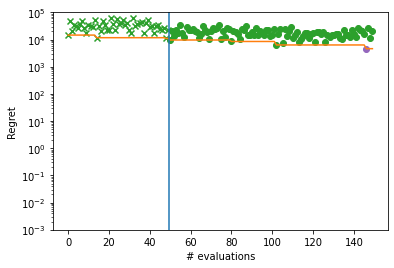

In [7]:
def plot_regret_with_min(dataset):
    observations = dataset.observations.numpy()
    arg_min_idx = tf.squeeze(tf.argmin(observations, axis=0))

    suboptimality = observations - F_MINIMUM.numpy()
    ax = plt.gca()
    plot_regret(
        suboptimality, ax, num_init=num_initial_points, idx_best=arg_min_idx
    )

    ax.set_yscale("log")
    ax.set_ylabel("Regret")
    ax.set_ylim(0.001, 100000)
    ax.set_xlabel("# evaluations")


plot_regret_with_min(dataset)

# Data transformation with the help of Ask-Tell interface

We will now show how data normalization can improve results achieved by Bayesian optimization.

We first write a simple function for doing the standardisation of the data, that is, we scale the data to have a zero mean and a variance equal to 1. We also return the mean and standard deviation parameters as we will use them to transform new points.

In [8]:
def normalise(x, mean=None, std=None):
    if mean is None:
        mean = tf.math.reduce_mean(x, 0, True)
    if std is None:
        std = tf.math.sqrt(tf.math.reduce_variance(x, 0, True))
    return (x - mean) / std, mean, std


Note that we also need to modify the search space, from the original $[-100, 100]$ for all 10 dimensions to the normalised space. For illustration, $[-1,1]$ will suffice here.

In [9]:
search_space = Box([-1], [1]) ** 10


Next we have to define our own Bayesian optimization loop where Ask-Tell optimizer performs optimisation, and we take care of data transformation and model fitting.

We are using a simple approach whereby we normalize the initial data and use estimated mean and standard deviation from the initial normalization for transforming the new points that the Bayesian optimization loop adds to the dataset.

In [10]:
x_sta, x_mean, x_std = normalise(initial_data.query_points)
y_sta, y_mean, y_std = normalise(initial_data.observations)
normalised_data = Dataset(query_points=x_sta, observations=y_sta)

dataset = initial_data
for step in range(num_steps):

    if step == 0:
        model = build_gp_model(normalised_data)
        model.optimize(normalised_data)
    else:
        model.update(normalised_data)
        model.optimize(normalised_data)

    # Asking for a new point to observe
    ask_tell = AskTellOptimizer(search_space, normalised_data, model)
    query_point = ask_tell.ask()

    # Transforming the query point back to the non-normalised space
    query_point = x_std * query_point + x_mean

    # Evaluating the function at the new query point
    new_data_point = observer(query_point)
    dataset = dataset + new_data_point

    # Normalize the dataset with the new query point and observation
    x_sta, _, _ = normalise(dataset.query_points, x_mean, x_std)
    y_sta, _, _ = normalise(dataset.observations, y_mean, y_std)
    normalised_data = Dataset(query_points=x_sta, observations=y_sta)


We inspect again the best point found by the optimizer and plot regret for each optimization step.

We can see that the optimization now gets almost to the global optimum of -210.

query point: [ 8.98300891 17.00171375 24.78719197 29.96769552 31.40902266 28.69907553
 26.50491577 23.84078396 17.31395633  9.09915015]
observation: [-201.88523399]


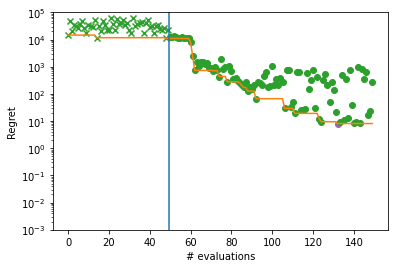

In [11]:
query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()

arg_min_idx = tf.squeeze(tf.argmin(observations, axis=0))

plot_regret_with_min(dataset)

print(f"query point: {query_points[arg_min_idx, :]}")
print(f"observation: {observations[arg_min_idx, :]}")

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)